# Reproducibility with original data

This tutorial demonstrates deconvolution on 10x Visium mouse brain data using SODB and Tangram.

A reference paper can be found at https://www.nature.com/articles/s41592-021-01264-7.

This tutorial refers to the following tutorial at https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html. At the same time, the way of loadding data is modified by using SODB.

（需要增加单细胞数据链接）

## Import packages and set configurations

In [1]:
# Import several Python packages, including:
# scanpy: a Python package for single-cell RNA sequencing analysis
import scanpy as sc
# squidpy: a Python package for spatial transcriptomics analysis
import squidpy as sq
# numpy: a Python package for scientific computing with arrays
import numpy as np
# pandas: a Python package for data manipulation and analysis
import pandas as pd
# anndata: a Python package for handling annotated data objects in genomics
import anndata as ad
# pathlib: a Python module for working with file system paths
import pathlib
# matplotlib: a Python plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl
# skimage: a Python package for image processing
import skimage

In [2]:
# Import tangram for spatial deconvolution
import tangram as tg

In [3]:
# print a header message, and the version of the squidpy and tangram packages
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8
squidpy==1.2.3
tangram==1.0.4


## Load a single cell dataset

In [11]:
# Load the reference single cell dataset
# The input sc data has been normalized and log-transformed
adata_sc = sc.read_h5ad('data/Visium/sc_mouse_cortex.h5ad')

In [12]:
# Print out the metadata of adata_sc
adata_sc

AnnData object with n_obs × n_vars = 21697 × 36826
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

<Axes: title={'center': 'cell_subclass'}, xlabel='UMAP1', ylabel='UMAP2'>

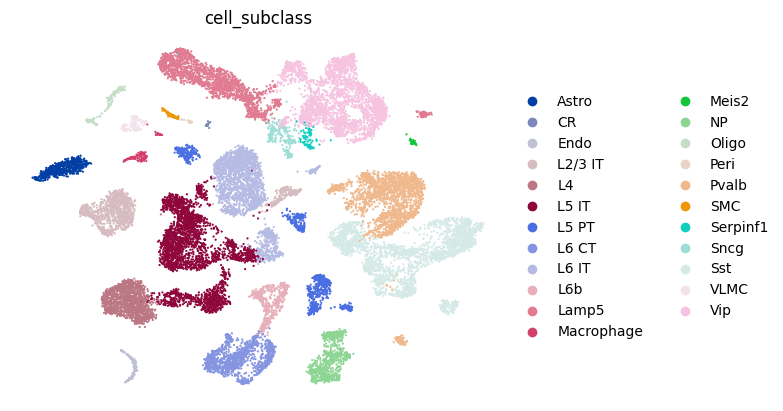

In [13]:
# Visualize a UMAP projection colored by cell_subclass
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False
)

## Streamline development of loading spatial data with SOBD

In [14]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [16]:
# Initialization
sodb = pysodb.SODB()

In [17]:
# Define the name of the dataset_name and experiment_name
dataset_name = 'Biancalani2021Deep'
experiment_name = 'visium_fluo_crop'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_st = sodb.load_experiment(dataset_name,experiment_name)

load experiment[visium_fluo_crop] in dataset[Biancalani2021Deep]


In [18]:
adata_st

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

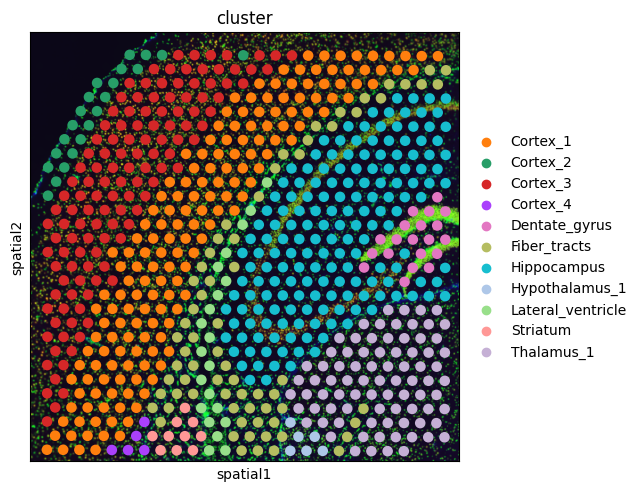

In [19]:
# Create a spatial scatter plot colored by cluster label
sq.pl.spatial_scatter(adata_st,color='cluster')

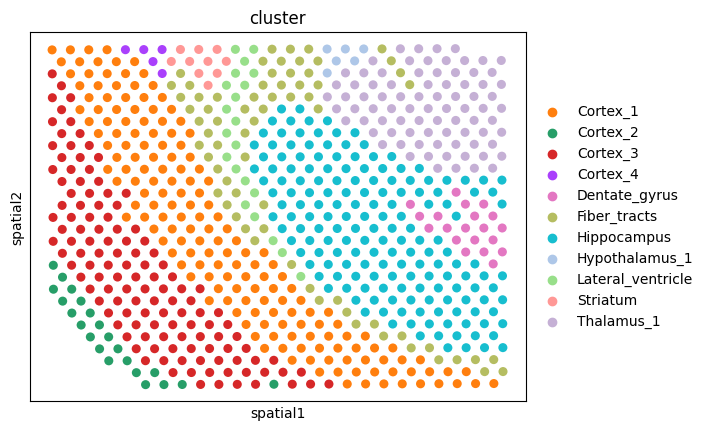

In [20]:
# Visualize embedding base on 'spatial' with points colored by 'cluster' label 
sc.pl.embedding(adata_st,basis='spatial',color='cluster')

In [21]:
# select a subset based on the "Cortex_{i}" of 'adata_st.obs.cluster'
# the arange of i is form 0 to 4
# And creates a copy of the resulting subset

adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()

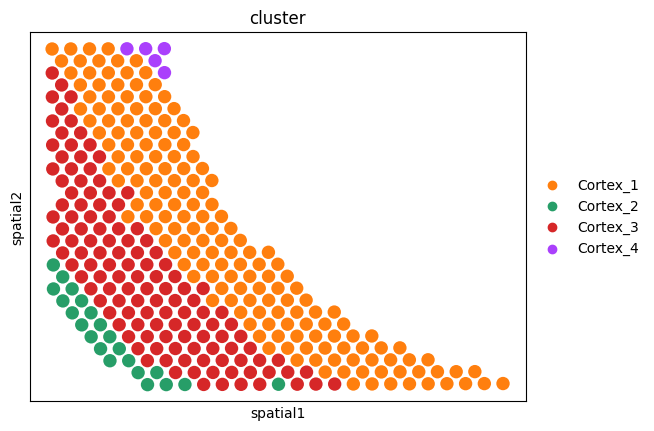

In [22]:
# Visualize embedding base on 'spatial' with points colored by a new 'cluster' label 
sc.pl.embedding(adata_st,basis='spatial',color='cluster')

## Preparation

In [23]:
# Perform differential gene expression analysis across 'cell_subclasses' in 'adata_sc'
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

In [24]:
# Create a Pandas DataFrame called "markers_df" by extracting the top 100 differentially expressed genes from 'adata_sc'
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# Create a NumPy array called "genes_sc" by extracting the unique values from the "value" column of a melted version of the "markers_df" 
genes_sc = np.unique(markers_df.melt().value.values)
# Extracte the names of genes from "adata_st"
genes_st = adata_st.var_names.values
# Create a Python list called "genes" 
# Contain the intersection of genes identified as differentially expressed in  "genes_sc" and genes detected in "genes_st".
genes = list(set(genes_sc).intersection(set(genes_st)))
# The length of "genes"
len(genes)

1281

## Perform Tangram for alignment

In [25]:
# Use the Tangram to align the gene expression profiles of "adata_sc" and "adata_st" based on the shared set of genes identified by the intersection of "genes_sc" and "genes_st".
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [26]:
# Use the map_cells_to_space function from the tangram to map cells from "adata_sc" onto "adata_st". 
# The mapping use "cells" mode, which assign each cell from adata_sc to a location within the spatial transcriptomics space based on its gene expression profile.
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    # target_count=adata_st.obs.cell_count.sum(),
    # density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.738, KL reg: 0.000


INFO:root:Saving results..


In [27]:
ad_map

AnnData object with n_obs × n_vars = 21697 × 324
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [28]:
# Project "Cell_subclass" annotations from a single-cell RNA sequencing (scRNA-seq) dataset onto a spatial transcriptomics dataset, based on a previously computed cell-to-space mapping
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [29]:
# Print adata_st.obsm['tangram_ct_pred']
adata_st.obsm['tangram_ct_pred']

,Pvalb,L4,Vip,L2/3 IT,Lamp5,NP,Sst,L5 IT,Oligo,L6 CT,...,L5 PT,Astro,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
AAATGGCATGTCTTGT-1,7.809727,0.602690,7.684955,0.826228,4.400264,2.589142,3.143504,5.196132,0.155253,7.294017,...,8.664869,2.573349,0.281258,0.412784,0.000076,0.000066,1.247531,0.070499,0.167258,0.627665
AACAACTGGTAGTTGC-1,5.715232,0.000604,14.581396,0.207686,5.556412,3.897364,3.344852,10.164038,0.450173,2.114142,...,7.679641,1.993195,1.645181,0.518714,0.078318,0.000459,0.534635,0.066145,0.000130,0.299213
AACAGGAAATCGAATA-1,4.831826,1.001870,7.364245,1.041612,6.277684,0.413503,8.242720,6.679482,0.496779,14.989484,...,0.562375,1.995712,0.680008,0.542730,0.200446,0.684655,0.651862,0.058122,0.000165,0.333420
AACCCAGAGACGGAGA-1,8.589804,4.175763,4.638950,4.470548,7.834509,0.000336,7.685515,12.343997,0.488403,2.658836,...,0.001456,2.909278,0.000471,0.560556,0.000042,0.336403,0.900331,0.000066,0.557967,0.550292
AACCGTTGTGTTTGCT-1,9.990313,5.441794,4.714663,1.678014,5.508845,1.483209,6.444257,14.175096,1.404791,0.000503,...,1.804151,1.123749,0.998521,1.451936,0.056683,0.000208,0.219766,0.034044,0.000118,0.581478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATTGGGTACCAC-1,5.641819,2.058308,12.881126,1.627751,3.359651,1.249576,13.079297,9.607204,0.419696,0.616700,...,6.947644,2.559545,0.000223,0.490524,0.019175,0.000077,0.261640,0.000564,0.250397,0.716284
TTGGCTCGCATGAGAC-1,3.322495,4.845051,4.550827,10.971983,7.764623,0.000582,12.342369,9.450901,0.159477,0.092170,...,0.000585,0.957426,0.001045,0.404693,0.006123,0.036123,0.290322,0.000344,0.237261,0.442137
TTGTATCACACAGAAT-1,3.573624,0.001394,7.127228,0.003228,4.591670,4.277098,9.285900,9.232115,0.697667,6.629681,...,4.475281,0.783166,0.737044,0.343111,0.067538,0.000370,0.167680,0.040888,0.239439,0.220072
TTGTGGCCCTGACAGT-1,9.355780,1.569948,9.292291,0.141470,0.208387,0.386280,5.018963,4.222025,0.805368,6.953451,...,3.673550,2.167665,1.065244,0.610526,0.061187,0.000065,0.723517,0.000139,0.355459,0.213958


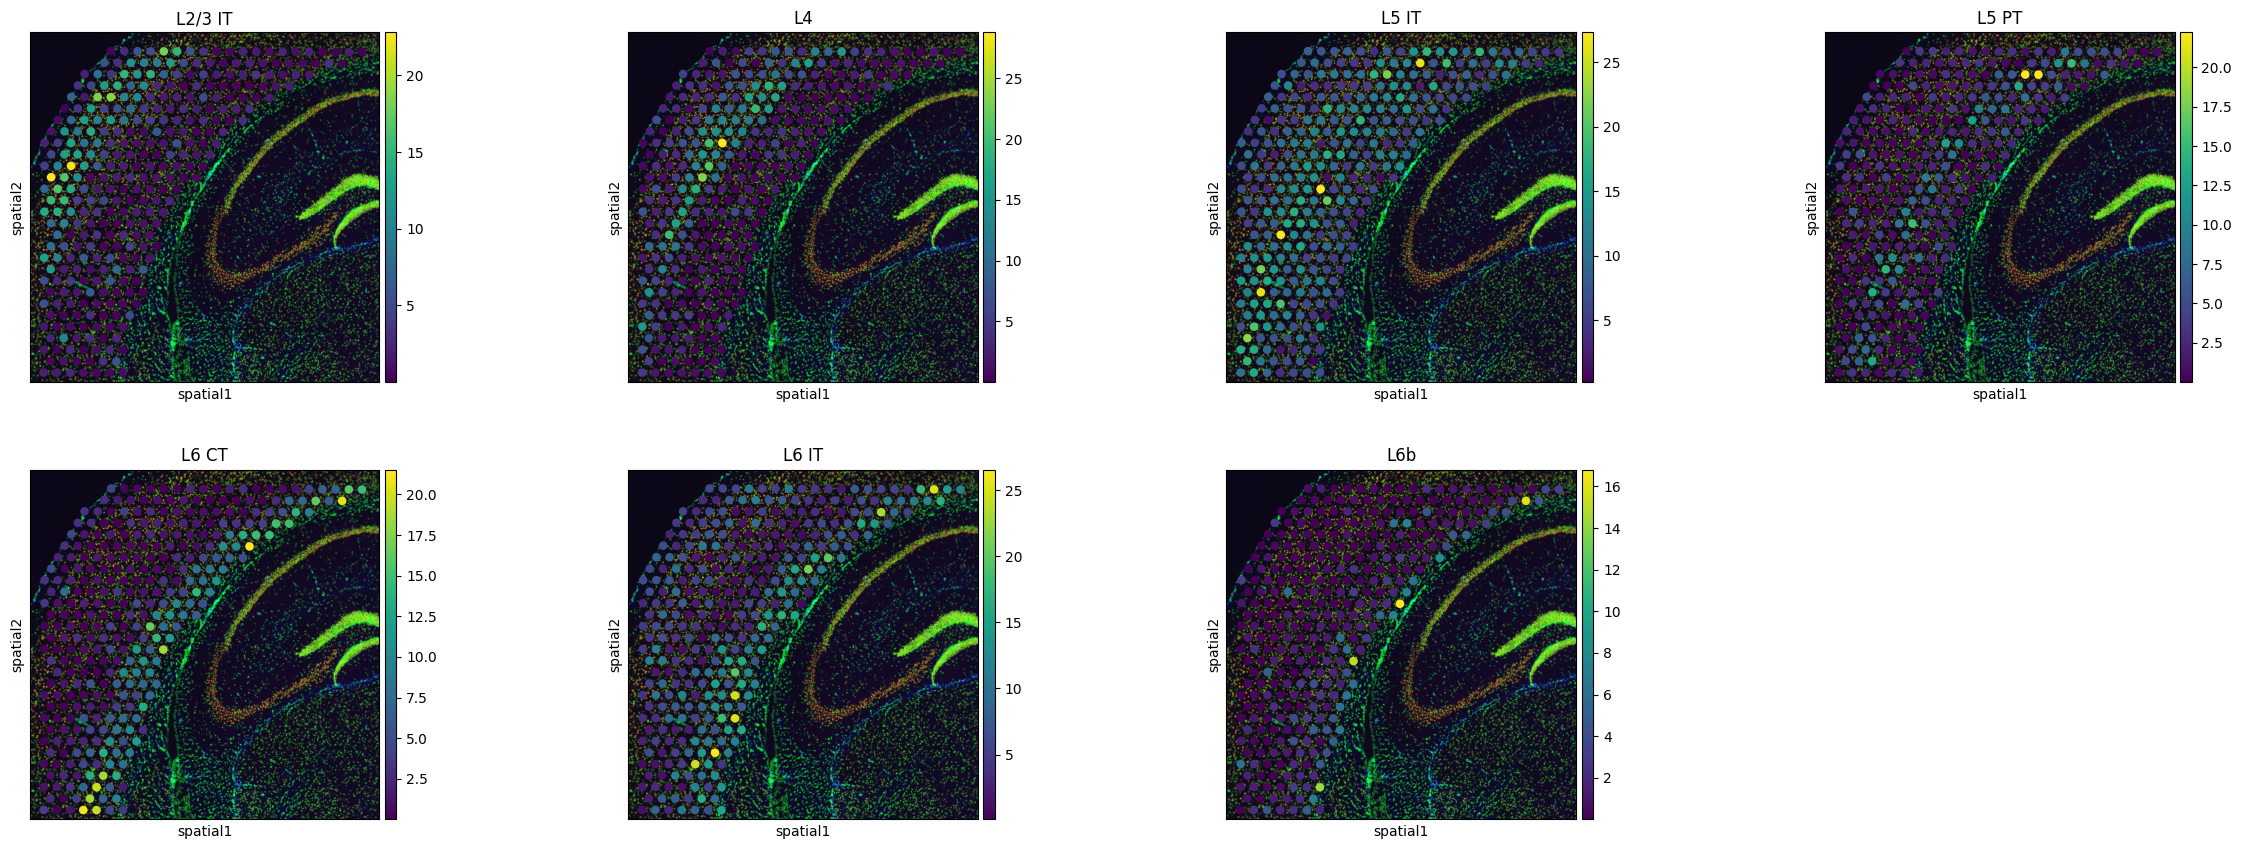

In [30]:
# Concatenate the predicted cell type labels computed by the tangram during the cell-to-space mapping step to 'adata_st.obs'
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)

# Create a spatial scatter plot showing the distribution of different cell types
sq.pl.spatial_scatter(
    adata_st,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)